In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
import osmnx as ox
import matplotlib.pyplot as plt
ox.config(log_file=True, log_console=True, use_cache=True)
import PyPDF2
import re
import warnings
from tqdm import tqdm
from glob import glob
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

# Creating a Luzon Boundary

In [2]:
conn = psycopg2.connect(dbname="postgis", 
                 user="gsa2021", 
                 password="5HOA&yn6$B", 
                 host="192.168.212.99", 
                 port=32771)

In [3]:
nominatim = Nominatim()
areaId = nominatim.query('Luzon, Philippines').areaId()

In [4]:
overpass = Overpass()
query = overpassQueryBuilder(area=areaId,
                             elementType='relation',
                             selector='"admin_level"="2.5"',
                             includeGeometry=True,out='body')
result = overpass.query(query)

In [5]:
result.elements()[0].tags()

{'admin_level': '2.5',
 'alt_name': 'Luzon Island Group',
 'boundary': 'administrative',
 'name': 'Luzon',
 'type': 'boundary',
 'wikidata': 'Q2673519',
 'wikipedia': 'nl:Luzon (eilandengroep)'}

In [6]:
df = pd.DataFrame(columns=['Name','geom'])
geo = gpd.read_file(str(result.elements()[0].geometry()))['geometry'][0]
df.loc[0] = [result.elements()[0].tag('name'),geo]
gdf = gpd.GeoDataFrame(df, geometry=df.geom)
gdf

,Name,geom,geometry
0,Luzon,"(POLYGON ((118.501564 7.62508, 118.564181 7.65...","MULTIPOLYGON (((118.50156 7.62508, 118.56418 7..."


<AxesSubplot:>

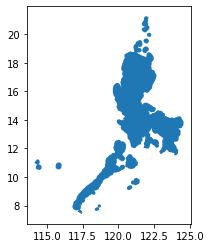

In [7]:
gdf.plot()

# Creating the Luzon Cities

In [8]:
ph_shp = gpd.read_postgis('''
SELECT * 
FROM gadm.ph
''',conn,geom_col='geom')
ph_shp.head()

,gid,gid_0,name_0,gid_1,name_1,nl_name_1,gid_2,name_2,varname_2,nl_name_2,type_2,engtype_2,cc_2,hasc_2,geom
0,1,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,None,Bayan|Munisipyo,Municipality,140101,PH.AB.BN,"MULTIPOLYGON (((120.62710 17.49300, 120.62177 ..."
1,2,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.2_1,Boliney,None,None,Bayan|Munisipyo,Municipality,140102,PH.AB.BL,"MULTIPOLYGON (((120.99042 17.39802, 120.98631 ..."
2,3,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.3_1,Bucay,None,None,Bayan|Munisipyo,Municipality,140103,PH.AB.BU,"MULTIPOLYGON (((120.70788 17.45395, 120.70621 ..."
3,4,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.4_1,Bucloc,None,None,Bayan|Munisipyo,Municipality,140104,PH.AB.BC,"MULTIPOLYGON (((120.78956 17.41699, 120.78922 ..."
4,5,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.5_1,Daguioman,None,None,Bayan|Munisipyo,Municipality,140105,PH.AB.DG,"MULTIPOLYGON (((120.92917 17.41307, 120.92464 ..."


<AxesSubplot:>

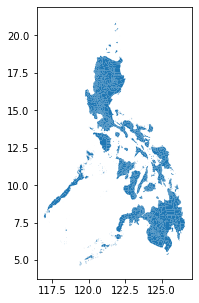

In [9]:
ph_shp.plot(figsize=(5,5))

In [10]:
luzon = gpd.overlay(gdf, ph_shp, how='intersection')

<AxesSubplot:>

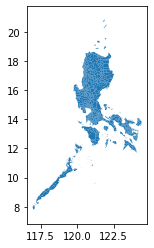

In [11]:
luzon.plot()

# Creating the Centroid of the Cities

In [12]:
luzon['centroid'] = luzon.centroid

df_luzon = luzon[['name_1','name_2','centroid']]
df_luzon  = gpd.GeoDataFrame(df_luzon , geometry=df_luzon.centroid)
df_luzon.head()

,name_1,name_2,centroid,geometry
0,Abra,Bangued,POINT (120.60718 17.60052),POINT (120.60718 17.60052)
1,Abra,Boliney,POINT (120.86822 17.37966),POINT (120.86822 17.37966)
2,Abra,Bucay,POINT (120.72253 17.52285),POINT (120.72253 17.52285)
3,Abra,Bucloc,POINT (120.84761 17.43768),POINT (120.84761 17.43768)
4,Abra,Daguioman,POINT (120.95165 17.45102),POINT (120.95165 17.45102)


<AxesSubplot:>

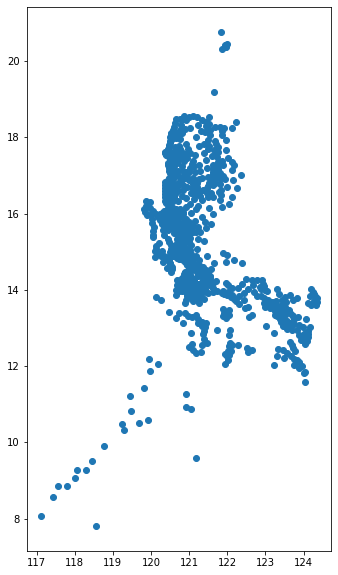

In [13]:
df_luzon.plot(figsize=(10,10))

# Merge Luzon with Population

In [14]:
pop = pd.read_csv('financial_pop.csv')
pop.head()

,pop,tot_local_sources,tot_tax_revenue,tot_current_oper_income,total_oper_expenses,net_oper_income,total_non_income_receipts,capital_expenditure,total_non_oper_expenditures,cash_balance_end,shp_province,shp_municipality
0,48163.0,74.045920,36.556294,230.577076,206.848717,23.728359,0.0,16.202464,21.181116,15.758681,Abra,Bangued
1,3573.0,0.115667,0.035633,56.689883,54.409910,2.279973,0.0,0.000000,0.030000,20.369743,Abra,Boliney
2,17115.0,1.736411,1.019565,93.647242,66.222389,27.424853,0.0,19.560034,20.792182,6.632671,Abra,Bucay
3,2501.0,0.273689,0.129150,44.789104,29.633181,15.155923,0.0,0.479569,0.656569,24.348356,Abra,Bucloc
4,2088.0,0.643801,0.277660,51.242322,47.848486,3.393836,0.0,0.000000,0.000000,6.511575,Abra,Daguioman


In [15]:
gdf_pop = df_luzon.merge(pop,left_on=['name_1','name_2'], right_on=['shp_province','shp_municipality'])
gdf_pop = gdf_pop.dropna()
gdf_pop.head()

,name_1,name_2,centroid,geometry,pop,tot_local_sources,tot_tax_revenue,tot_current_oper_income,total_oper_expenses,net_oper_income,total_non_income_receipts,capital_expenditure,total_non_oper_expenditures,cash_balance_end,shp_province,shp_municipality
0,Abra,Bangued,POINT (120.60718 17.60052),POINT (120.60718 17.60052),48163.0,74.045920,36.556294,230.577076,206.848717,23.728359,0.0,16.202464,21.181116,15.758681,Abra,Bangued
1,Abra,Boliney,POINT (120.86822 17.37966),POINT (120.86822 17.37966),3573.0,0.115667,0.035633,56.689883,54.409910,2.279973,0.0,0.000000,0.030000,20.369743,Abra,Boliney
2,Abra,Bucay,POINT (120.72253 17.52285),POINT (120.72253 17.52285),17115.0,1.736411,1.019565,93.647242,66.222389,27.424853,0.0,19.560034,20.792182,6.632671,Abra,Bucay
3,Abra,Bucloc,POINT (120.84761 17.43768),POINT (120.84761 17.43768),2501.0,0.273689,0.129150,44.789104,29.633181,15.155923,0.0,0.479569,0.656569,24.348356,Abra,Bucloc
4,Abra,Daguioman,POINT (120.95165 17.45102),POINT (120.95165 17.45102),2088.0,0.643801,0.277660,51.242322,47.848486,3.393836,0.0,0.000000,0.000000,6.511575,Abra,Daguioman


# Creating and Plotting the Substations

In [16]:
nominatim = Nominatim()
areaId = nominatim.query('Luzon,Philippines').areaId()

In [17]:
overpass = Overpass()
query = overpassQueryBuilder(area=areaId, elementType='way', selector='"power"="substation"', includeGeometry=True,out='body')
result = overpass.query(query)
result.countElements()

494

In [18]:
df_subs = pd.DataFrame(columns=['id','name','geom'])
for y,x in enumerate(result.elements()):
    list1 = []
    try:
        geo = gpd.read_file(str(x.geometry()))['geometry'][0]
        df_subs.loc[y] = [x.id(),x.tag('name'),geo]
    except:
        print(x.tag('name'))
        pass

In [19]:
gdf_subs = gpd.GeoDataFrame(df_subs, geometry=df_subs.geom)
gdf_subs.head()

,id,name,geom,geometry
0,28701585,Balibago Substation,"POLYGON ((121.102106 14.293563, 121.101882 14....","POLYGON ((121.10211 14.29356, 121.10188 14.293..."
1,30331256,Magallanes Substation,"POLYGON ((121.020812 14.537707, 121.02112 14.5...","POLYGON ((121.02081 14.53771, 121.02112 14.537..."
2,30618817,Paco Substation,"POLYGON ((120.99821 14.58017, 120.998159 14.58...","POLYGON ((120.99821 14.58017, 120.99816 14.580..."
3,30665662,San Jose del Monte Substation,"POLYGON ((121.044865 14.818748, 121.046158 14....","POLYGON ((121.04487 14.81875, 121.04616 14.818..."
4,30679817,Sampaloc Substation,"POLYGON ((120.990661 14.612684, 120.990579 14....","POLYGON ((120.99066 14.61268, 120.99058 14.612..."


# dropping the Null Names of substations

In [20]:
subs_luzon = gpd.overlay(gdf, gdf_subs, how='intersection')[['name','geometry']]
subs_luzon['centroid'] = subs_luzon.centroid
subs_luzon = subs_luzon[['name','centroid']]
subs_luzon  = gpd.GeoDataFrame(subs_luzon , geometry=subs_luzon.centroid)

#dropping none values of substation names

subs_luzon = subs_luzon[~subs_luzon['name'].isnull()]
subs_luzon['matchingname1'] = subs_luzon['name'].str.replace(' Substation','').str.lower()
subs_luzon.head()

,name,centroid,geometry,matchingname1
0,Balibago Substation,POINT (121.10201 14.29399),POINT (121.10201 14.29399),balibago
1,Magallanes Substation,POINT (121.02138 14.53764),POINT (121.02138 14.53764),magallanes
2,Paco Substation,POINT (120.99863 14.58055),POINT (120.99863 14.58055),paco
3,San Jose del Monte Substation,POINT (121.04724 14.82088),POINT (121.04724 14.82088),san jose del monte
4,Sampaloc Substation,POINT (120.99046 14.61261),POINT (120.99046 14.61261),sampaloc


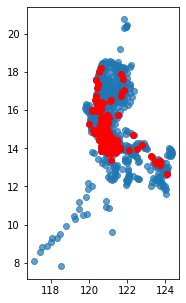

In [21]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
gdf_pop.plot(ax=ax,alpha=0.7)
subs_luzon.plot(ax=ax,color='red');

# Creating a bounding box to limit only within the substation

In [22]:
from shapely.geometry import Point, Polygon
bbox = subs_luzon.total_bounds

p1 = Point(bbox[0], bbox[3])
p2 = Point(bbox[2], bbox[3])
p3 = Point(bbox[2], bbox[1])
p4 = Point(bbox[0], bbox[1])

np1 = (p1.coords.xy[0][0], p1.coords.xy[1][0])
np2 = (p2.coords.xy[0][0], p2.coords.xy[1][0])
np3 = (p3.coords.xy[0][0], p3.coords.xy[1][0])
np4 = (p4.coords.xy[0][0], p4.coords.xy[1][0])

bb_polygon = Polygon([np1, np2, np3, np4])

df2 = gpd.GeoDataFrame(gpd.GeoSeries(bb_polygon), columns=['geometry'])

df3 = gpd.overlay(df2, luzon)

df4 = df3.merge(pop,left_on=['name_1','name_2'], right_on=['shp_province','shp_municipality'])
df4.head()

,Name,geom,gid,gid_0,name_0,gid_1,name_1,nl_name_1,gid_2,name_2,...,tot_tax_revenue,tot_current_oper_income,total_oper_expenses,net_oper_income,total_non_income_receipts,capital_expenditure,total_non_oper_expenditures,cash_balance_end,shp_province,shp_municipality
0,Luzon,"(POLYGON ((118.501564 7.62508, 118.564181 7.65...",1,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,...,36.556294,230.577076,206.848717,23.728359,0.0,16.202464,21.181116,15.758681,Abra,Bangued
1,Luzon,"(POLYGON ((118.501564 7.62508, 118.564181 7.65...",2,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.2_1,Boliney,...,0.035633,56.689883,54.409910,2.279973,0.0,0.000000,0.030000,20.369743,Abra,Boliney
2,Luzon,"(POLYGON ((118.501564 7.62508, 118.564181 7.65...",3,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.3_1,Bucay,...,1.019565,93.647242,66.222389,27.424853,0.0,19.560034,20.792182,6.632671,Abra,Bucay
3,Luzon,"(POLYGON ((118.501564 7.62508, 118.564181 7.65...",4,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.4_1,Bucloc,...,0.129150,44.789104,29.633181,15.155923,0.0,0.479569,0.656569,24.348356,Abra,Bucloc
4,Luzon,"(POLYGON ((118.501564 7.62508, 118.564181 7.65...",5,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.5_1,Daguioman,...,0.277660,51.242322,47.848486,3.393836,0.0,0.000000,0.000000,6.511575,Abra,Daguioman


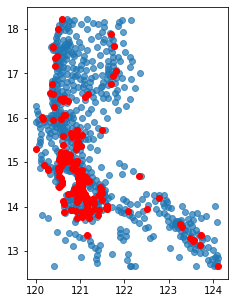

In [23]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
df4.centroid.plot(ax=ax,alpha=0.7)
subs_luzon.plot(ax=ax,color='red');

# Parsing the IEMOP PDF

In [24]:
fixed_pdf = PyPDF2.PdfFileReader('datasets/energy/WESM-MNM_182.pdf')
p29 = fixed_pdf.getPage(29).extractText()
p29=p29.replace('\n4\n','\n').replace('\n3\n','\n')
des = re.findall(r'\nDescription\n ([\s\S.]+?)\nSubject',p29)[0]
p29l = re.findall(r'(\n.+?\n \n.+?\n)',des)

dfa = pd.DataFrame(columns=['code','name'])
for y,x in enumerate(p29l):
    x1 = re.findall(r'\n(.+)_',x)[0]
    try:
        x2 = re.findall(r'\n(.+) substation',x)[0]
    except:
        try:
            x2 = re.findall(r'\n(.+)? \bstation\b',x)[0]
        except:
            try:
                x2 = re.findall(r'\n(.+) ',x)[0]
            except:
                pass
    dfa.loc[y] = [x1,x2]
dfa.loc[11,'name']='Santiago'
dfa=dfa.drop_duplicates()

In [25]:
p27 = fixed_pdf.getPage(27).extractText()
p27=p27.replace('\n2\n','\n').replace('\n3\n','\n')
des = re.findall(r'\nDescription\n ([\s\S.]+?)\nSubject',p27)[0]
p27l = re.findall(r'(\n.+?\n \n.+?\n)',des)
df1a = pd.DataFrame(columns=['code','name'])
for y,x in enumerate(p27l):
    x1 = re.findall(r'\n(.+)_',x)[0]
    try:
        x2 = re.findall(r'\n(.+) substation',x)[0]
    except:
        try:
            x2 = re.findall(r'\n(.+)? \bstation\b',x)[0]
        except:
            try:
                x2 = re.findall(r'\n(.+) ',x)[0]
            except:
                pass
    df1a.loc[y] = [x1,x2]
df1a.loc[8,'name']='La Union'
df1a=df1a.drop_duplicates()

In [26]:
p28 = fixed_pdf.getPage(28).extractText()
p28=p28.replace('\n2\n','\n').replace('\n3\n','\n').replace('\n-\n','').replace(' \nPlant\n',' ')
des = re.findall(r'\nDescription\n ([\s\S.]+?)\nSubject',p28)[0]
p28l = re.findall(r'(\n.+?\n \n.+?\n)',des)
df2a = pd.DataFrame(columns=['code','name'])
for y,x in enumerate(p28l):
    x1 = re.findall(r'\n(.+)_',x)[0]
    try:
        x2 = re.findall(r'\n(.+) substation',x)[0]
    except:
        try:
            x2 = re.findall(r'\n(.+)? \bstation\b',x)[0]
        except:
            try:
                x2 = re.findall(r'\n(.+) ',x)[0]
            except:
                pass
    df2a.loc[y] = [x1,x2]
df2a.loc[35,'name']='GN'
df2a.loc[43,'name']='San Esteban'
df2a=df2a.drop_duplicates()

In [27]:
p30 = fixed_pdf.getPage(30).extractText()
p30=p30.replace('\n2\n','\n').replace('\n3\n','\n').replace('\n-\n','').replace(' \nPlant\n',' ')
des = re.findall(r'\nDescription\n ([\s\S.]+?)\nsubject',p30)[0]
p30l = re.findall(r'(\n.+?\n \n.+?\n)',des)[:-2]
df3a = pd.DataFrame(columns=['code','name'])
for y,x in enumerate(p30l):
    x1 = re.findall(r'\n(.+)_',x)[0]
    try:
        x2 = re.findall(r'\n(.+) substation',x)[0]
    except:
        try:
            x2 = re.findall(r'\n(.+)? \bstation\b',x)[0]
        except:
            try:
                x2 = re.findall(r'\n(.+) ',x)[0]
            except:
                pass
    df3a.loc[y] = [x1,x2]
df3a=df3a.drop_duplicates()

In [28]:
matcher = []
for x in range(31, 41):
    pages = fixed_pdf.getPage(x).extractText()
    pages_filter = re.findall(r'\n(1[\w\_\d]*)\n \n([\w\d]*)\n', pages)
    matcher.extend(pages_filter)

for x in range(41, 56):
    pages = fixed_pdf.getPage(x).extractText()
    pages_filter = re.findall(r'\n(2[\w\_\d]*)\n \n([\w\d]*)\n', pages)
    matcher.extend(pages_filter)
    
for x in range(56, 66):
    pages = fixed_pdf.getPage(x).extractText()
    pages_filter = re.findall(r'\n(3[\w\_\d]*)\n \n([\w\d]*)\n', pages)
    matcher.extend(pages_filter)    

In [29]:
mapping = {'ambklao':'ambuklao', 'bakun':'alilem',  'balingueo':'dagupan',
          'bcnotan': 'bacnotan', 'byombng':'bayombong', 'cbntuan':'cabanatuan',
           'cncepcn': 'concepcion', 'cruzdan':'krus na daan', 'curimao':'currimao',
           'ehvsjos':'san jose del monte', 'ehvnagsaag': 'nagsaag ehv', 'latrini': 'la trinidad',
           'lbrador': 'national grid corporation of the philippines - labrador', 'nagsaag': 'nagsaag ehv',
           'bccpp':'bataan combined cycle power plant (bccpp)', 'msinloc':'masinloc', 'olongap': 'olongapo',
           'pantaba': 'pantabangan', 'snestbn':'san esteban', 'snjose':'san jose del monte',
           'snmanuel': 'san manuel', 'sntgo':'santiago', 'snroque': 'san roque',
           'tgegarao':'tuguegarao', 'salong': 'salonga',
           'caliray': 'caliraya', 'claca': 'calaca', 'dasma':'dasmariñas', 'dasmaehv': 'dasmariñas',
           'kalyaan': 'kalayaan', 'mkban':'calauan', 'mlaya': 'malaya', 'pgbilao':'pagbilao',
           'starita': 'sta rita', 'strosa': 'sta rosa', 'tayabehv': 'tayabas', 'bpc': 'bantay', 'bntay':'bantay',
           'mariveles': 'mariveles ehv', 'subic':'subic enerzone central', 'mexico':'ngcp mexico',
           'bppc': 'bauang', 'binan':'biñan', 'naga':'naga converter station', 'slpgc':'calaca'
          }

addl_matcher = pd.DataFrame(matcher).rename(columns={0:'code', 1:'name'})
addl_matcher['matchingname2'] = addl_matcher['name'].apply(lambda x: re.findall(r'[A-Za-z]+', x)[0].lower())
addl_matcher = addl_matcher.replace({"matchingname2": mapping})
addl_matcher = addl_matcher.drop_duplicates()

In [30]:
df4a = pd.concat([dfa,df1a,df2a,df3a]).reset_index(drop=True)
df4a['matchingname2'] = df4a['name'].str.lower()

df4a = pd.concat([df4a, addl_matcher])
df4a

,code,name,matchingname2
0,1SNEST,San Esteban,san esteban
1,1SNJOS,San Jose,san jose
2,1SNJOSE,San Jose,san jose
3,1SNMAN,San Manuel,san manuel
4,1SNTGO,Santiago,santiago
...,...,...,...
1367,3STROS_T1L1,3STROSA,sta rosa
1459,3TAYAB_SS,3TAYABEHV,tayabas
1460,3TAYAB_T1L1,3TAYABAS,tayabas
1470,3TIWIA_SS,3TIWI,tiwi


# Filtering only the subsation that are in iemop

In [31]:
subs_iemop = subs_luzon[subs_luzon['matchingname1'].isin(df4a['matchingname2'])]
subs_iemop = subs_iemop.reset_index(drop=True)
len(subs_iemop)

49

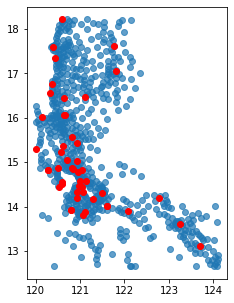

In [32]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
df4.centroid.plot(ax=ax,alpha=0.7)
subs_iemop.plot(ax=ax,color='red');

# Determine which substation did not match

In [33]:
a = pd.merge(pd.DataFrame(subs_luzon['matchingname1']), 
         pd.DataFrame(addl_matcher['matchingname2']), 
         left_on='matchingname1', right_on='matchingname2',
         how='outer').dropna(subset=['matchingname2'])
a[a['matchingname1'].isna()]['matchingname2'].unique()

#all of these are industrial loads. 

array(['ambuklao', 'angat', 'alilem', 'dagupan', 'binga', 'burgos',
       'cascnan', 'currimao', 'cawago', 'kdam', 'magat', 'masinloc',
       'pagudpud', 'pantabangan', 'angsjo', 'santiago', 'san roque',
       'sual', 't', 'public', 'donaimelda', 'taytay', 'manila',
       'caliraya', 'salonga', 'ilijan', 'kalayaan', 'malaya', 'pagbilao',
       'mauban', 'sta rita', 'sta rosa', 'tiwi'], dtype=object)

# Getting the closest substation to the cities

In [34]:
c = []
df4['substation'] = None
for x in range(0,len(df4)):
    shortest_sub = subs_iemop.distance(df4.centroid[x]).sort_values().index[0]
    df4.loc[x,'substation'] = subs_iemop.loc[shortest_sub]['matchingname1']

In [35]:
ratio1 = df4[['pop','substation']].groupby('substation').sum().to_dict()['pop']
df4['pop_total_subs'] = df4['substation'].map(ratio1)
df4['ratio_pop'] = df4['pop']/df4['pop_total_subs']
df4[['name_2','pop','substation','ratio_pop']].head()

,name_2,pop,substation,ratio_pop
0,Bangued,48163.0,bantay,0.104548
1,Boliney,3573.0,san esteban,0.007623
2,Bucay,17115.0,san esteban,0.036517
3,Bucloc,2501.0,san esteban,0.005336
4,Daguioman,2088.0,san esteban,0.004455


In [36]:
subs_version2 = subs_luzon[subs_luzon['matchingname1'].isin(df4['substation'])]

# Getting the features within the Cities

In [37]:
provinces = ('Abra', 'Apayao', 'Benguet', 'Ifugao', 'Kalinga', 
            'Mountain Province','Metropolitan Manila', 'Ilocos Norte', 
            'Ilocos Sur', 'La Union', 'Pangasinan', 'Cagayan', 'Isabela', 
            'Nueva Vizcaya','Quirino','Aurora', 'Bataan', 'Bulacan', 
            'Nueva Ecija', 'Pampanga', 'Tarlac', 'Zambales', 'Batangas', 
            'Cavite', 'Laguna', 'Quezon', 'Rizal', 'Albay', 'Camarines Norte',
            'Camarines Sur','Sorsogon', 'Catanduanes', 'Marinduque', 
            'Occidental Mindoro', 'Oriental Mindoro','Romblon')

amenities = pd.read_sql(f"""
                        SELECT g.name_1, g.name_2, p.amenity as feature,
                               count(*) AS count
                        FROM gadm.ph_brgy g
                        JOIN public.ph_point p ON st_within(p.way, g.geom)
                        WHERE g.name_1 in {provinces} AND p.amenity IS NOT NULL
                        GROUP BY g.name_1, g.name_2, p.amenity
                        ORDER BY count DESC
                        """, conn)
amenities

,name_1,name_2,feature,count
0,Metropolitan Manila,Quezon City,restaurant,741
1,Metropolitan Manila,Makati City,restaurant,678
2,Metropolitan Manila,Quezon City,bank,471
3,Metropolitan Manila,Quezon City,fast_food,467
4,Metropolitan Manila,Makati City,bank,462
...,...,...,...,...
7417,Rizal,Tanay,motorcycle_parking,1
7418,Ilocos Norte,San Nicolas,bus_station,1
7419,Metropolitan Manila,Las Piñas,vending_machine,1
7420,Metropolitan Manila,Las Piñas,veterinary,1


In [38]:
tourism = pd.read_sql(f"""
                        SELECT g.name_1, g.name_2, p.tourism as feature,
                               count(*) AS count
                        FROM gadm.ph_brgy g
                        JOIN public.ph_point p ON st_within(p.way, g.geom)
                        WHERE g.name_1 in {provinces} AND p.tourism IS NOT NULL
                        GROUP BY g.name_1, g.name_2, p.tourism
                        ORDER BY count DESC
                        """, conn)
tourism

,name_1,name_2,feature,count
0,Metropolitan Manila,Manila,hotel,74
1,Pampanga,Mabalacat,hotel,59
2,Batangas,Mabini,hotel,56
3,Metropolitan Manila,Makati City,hotel,54
4,Metropolitan Manila,Quezon City,hotel,52
...,...,...,...,...
1875,Sorsogon,Irosin,hostel,1
1876,Sorsogon,Irosin,viewpoint,1
1877,Sorsogon,Magallanes,attraction,1
1878,Sorsogon,Matnog,camp_site,1


In [39]:
leisure = pd.read_sql(f"""
                        SELECT g.name_1, g.name_2, p.leisure as feature,
                               count(*) AS count
                        FROM gadm.ph_brgy g
                        JOIN public.ph_point p ON st_within(p.way, g.geom)
                        WHERE g.name_1 in {provinces} AND p.leisure IS NOT NULL
                        GROUP BY g.name_1, g.name_2, p.leisure
                        ORDER BY count DESC
                        """, conn)
leisure

,name_1,name_2,feature,count
0,Metropolitan Manila,Quezon City,playground,30
1,Metropolitan Manila,Quezon City,sports_centre,29
2,Zambales,Subic,pitch,27
3,Laguna,Calamba City,water_park,24
4,Metropolitan Manila,Quezon City,pitch,18
...,...,...,...,...
732,Rizal,Antipolo City,park,1
733,Laguna,Santa Rosa City,resort,1
734,Cavite,General Mariano Alvarez,fitness_centre,1
735,Mountain Province,Bontoc,park,1


In [40]:
historic = pd.read_sql(f"""
                        SELECT g.name_1, g.name_2, p.historic as feature,
                               count(*) AS count
                        FROM gadm.ph_brgy g
                        JOIN public.ph_point p ON st_within(p.way, g.geom)
                        WHERE g.name_1 in {provinces} AND p.historic IS NOT NULL
                        GROUP BY g.name_1, g.name_2, p.historic
                        ORDER BY count DESC
                        """, conn)
historic

,name_1,name_2,feature,count
0,Metropolitan Manila,Manila,memorial,88
1,Metropolitan Manila,Quezon City,monument,50
2,Pangasinan,Alaminos City,monument,30
3,Metropolitan Manila,Manila,monument,29
4,Laguna,Santa Cruz,monument,16
...,...,...,...,...
381,Pampanga,Arayat,memorial,1
382,Camarines Sur,Magarao,monument,1
383,Pangasinan,Alaminos City,memorial,1
384,Cavite,Indang,marker,1


In [41]:
highway = pd.read_sql(f"""
                        SELECT g.name_1, g.name_2, p.highway as feature,
                               count(*) AS count
                        FROM gadm.ph_brgy g
                        JOIN public.ph_point p ON st_within(p.way, g.geom)
                        WHERE g.name_1 in {provinces} AND p.highway IS NOT NULL
                        GROUP BY g.name_1, g.name_2, p.highway
                        ORDER BY count DESC
                        """, conn)
highway

,name_1,name_2,feature,count
0,Cavite,Dasmariñas,street_lamp,1174
1,Pampanga,San Fernando City,turning_circle,369
2,Cavite,Dasmariñas,crossing,257
3,Metropolitan Manila,Makati City,traffic_signals,248
4,Metropolitan Manila,Quezon City,traffic_signals,223
...,...,...,...,...
1069,Bulacan,Hagonoy,bus_stop,1
1070,Rizal,Angono,turning_loop,1
1071,Isabela,Alicia,bus_stop,1
1072,Metropolitan Manila,Parañaque,jeepney_stop,1


In [42]:
features = pd.concat([amenities, leisure, tourism, highway, historic])
features

,name_1,name_2,feature,count
0,Metropolitan Manila,Quezon City,restaurant,741
1,Metropolitan Manila,Makati City,restaurant,678
2,Metropolitan Manila,Quezon City,bank,471
3,Metropolitan Manila,Quezon City,fast_food,467
4,Metropolitan Manila,Makati City,bank,462
...,...,...,...,...
381,Pampanga,Arayat,memorial,1
382,Camarines Sur,Magarao,monument,1
383,Pangasinan,Alaminos City,memorial,1
384,Cavite,Indang,marker,1


In [43]:
features = features.groupby(['name_1', 'name_2','feature']).sum()['count'].reset_index()

In [44]:
len(features.name_2.unique())

590

In [45]:
features_count = pd.pivot_table(features, values='count', 
                                 index=['name_1', 'name_2'],
                                 columns='feature' ).fillna(0).reset_index()
features_count

feature,name_1,name_2,BPI ATM,Barangay Hall,Barangay Yakal Hall,Barangay_Police_Outpost,Basketball Court,Budget Accomodation,CheckPoint,Clubhouse,...,water_point,waterwell,wayside_cross,wayside_shrine,wellness,wheeler,wilderness_hut,wrecker_service,yes,zoo
0,Abra,Bangued,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Abra,Manabo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Abra,San Juan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Abra,San Quintin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Abra,Tubo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,Zambales,San Felipe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
661,Zambales,San Marcelino,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
662,Zambales,San Narciso,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
663,Zambales,Santa Cruz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Getting the Demand Energy 

In [46]:
demand = pd.read_csv('datasets/energy/energydemand.csv').dropna()

In [47]:
def clearname(x):
    x = re.findall(r'(.+)_',x)[0]
    return x

In [48]:
demand['name2'] = demand['RESOURCE_ID'].apply(clearname)

In [49]:
def clean_data(x):
    x1 = x.split('/')
    return pd.Series([x1[2],x1[0],x1[1]])

In [50]:
demand2 = demand[demand['name2'].isin(df4a['code'])]
demand3 = demand2.groupby(['name2','DELIVERY_DATE','DELIVERY_HOUR']).sum().reset_index()
demand3[['Year','Month','Day']] = demand3['DELIVERY_DATE'].apply(clean_data)
demand3['Time'] = demand3['DELIVERY_HOUR']
demand3 = demand3[['name2','Year','Month','Day','Time','MW']]
demand3

,name2,Year,Month,Day,Time,MW
0,1AEC,2021,02,01,1.0,24.7
1,1AEC,2021,02,01,2.0,23.9
2,1AEC,2021,02,01,3.0,22.9
3,1AEC,2021,02,01,4.0,22.3
4,1AEC,2021,02,01,5.0,22.4
...,...,...,...,...,...,...
153787,3TAYAB,2021,04,30,20.0,73.1
153788,3TAYAB,2021,04,30,21.0,71.3
153789,3TAYAB,2021,04,30,22.0,69.4
153790,3TAYAB,2021,04,30,23.0,64.3


# Get only February

In [51]:
demand4 = demand3.query('Month == "02"')
demand4

,name2,Year,Month,Day,Time,MW
0,1AEC,2021,02,01,1.0,24.7
1,1AEC,2021,02,01,2.0,23.9
2,1AEC,2021,02,01,3.0,22.9
3,1AEC,2021,02,01,4.0,22.3
4,1AEC,2021,02,01,5.0,22.4
...,...,...,...,...,...,...
152323,3TAYAB,2021,02,28,20.0,68.3
152324,3TAYAB,2021,02,28,21.0,66.3
152325,3TAYAB,2021,02,28,22.0,63.3
152326,3TAYAB,2021,02,28,23.0,59.0


# Merging all Data

In [52]:
df5 = pd.DataFrame(df4[['shp_province','shp_municipality', 'substation','ratio_pop']])
df5['code'] = df5['substation'].map(df4a[['matchingname2','code']].set_index('matchingname2').to_dict()['code'])
df5

,shp_province,shp_municipality,substation,ratio_pop,code
0,Abra,Bangued,bantay,0.104548,1BPC_T1L1
1,Abra,Boliney,san esteban,0.007623,1SNEST_T3L2
2,Abra,Bucay,san esteban,0.036517,1SNEST_T3L2
3,Abra,Bucloc,san esteban,0.005336,1SNEST_T3L2
4,Abra,Daguioman,san esteban,0.004455,1SNEST_T3L2
...,...,...,...,...,...
668,Zambales,Palauig,botolan,0.131183,1BOTOLAN_SS
669,Zambales,San Antonio,olongapo,0.130159,1OLONG_T3L3
670,Zambales,San Felipe,botolan,0.087024,1BOTOLAN_SS
671,Zambales,San Marcelino,olongapo,0.126419,1OLONG_T3L3


In [53]:
df6 = df5.merge(features_count,left_on=['shp_municipality'],right_on=['name_2']).drop(['name_2'],axis=1)
df6

,shp_province,shp_municipality,substation,ratio_pop,code,name_1,BPI ATM,Barangay Hall,Barangay Yakal Hall,Barangay_Police_Outpost,...,water_point,waterwell,wayside_cross,wayside_shrine,wellness,wheeler,wilderness_hut,wrecker_service,yes,zoo
0,Abra,Bangued,bantay,0.104548,1BPC_T1L1,Abra,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Abra,Dolores,bantay,0.024562,1BPC_T1L1,Quezon,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Quezon,Dolores,calauan,0.026665,3ORMAT_SS,Quezon,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Abra,La Paz,bantay,0.033509,1BPC_T1L1,Tarlac,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Tarlac,La Paz,concepcion,0.068096,1CNCEP_TEI,Tarlac,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,Zambales,Olongapo City,subic enerzone central,0.886282,1SUBIC_T3L1,Zambales,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
846,Zambales,Palauig,botolan,0.131183,1BOTOLAN_SS,Zambales,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
847,Zambales,San Felipe,botolan,0.087024,1BOTOLAN_SS,Zambales,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
848,Zambales,San Marcelino,olongapo,0.126419,1OLONG_T3L3,Zambales,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
working_df = demand4.merge(df6,
                           left_on=['name2'],
                           right_on=['code']).drop(['name2'],axis=1)
working_df['Demand'] = working_df['MW']*working_df['ratio_pop']
working_df = working_df.drop(['MW','ratio_pop'],axis=1)
working_df[['Year','Month','Day','Time']] = working_df[['Year','Month','Day','Time']].astype('int32')
working_df

,Year,Month,Day,Time,shp_province,shp_municipality,substation,code,name_1,BPI ATM,...,waterwell,wayside_cross,wayside_shrine,wellness,wheeler,wilderness_hut,wrecker_service,yes,zoo,Demand
0,2021,2,1,1,Batangas,San Juan,san jose,1SNJOSE,Abra,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.104250
1,2021,2,1,1,Batangas,San Juan,san jose,1SNJOSE,Batangas,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.104250
2,2021,2,1,1,Batangas,San Juan,san jose,1SNJOSE,Ilocos Sur,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.104250
3,2021,2,1,1,Batangas,San Juan,san jose,1SNJOSE,La Union,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.104250
4,2021,2,1,1,Batangas,San Juan,san jose,1SNJOSE,Metropolitan Manila,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,13.104250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45019,2021,2,28,24,Cavite,Magallanes,amadeo,3AMADEO,Sorsogon,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.076222
45020,2021,2,28,24,Cavite,Indang,amadeo,3AMADEO,Cavite,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.879179
45021,2021,2,28,24,Cavite,Maragondon,amadeo,3AMADEO,Cavite,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.105606
45022,2021,2,28,24,Cavite,Silang,amadeo,3AMADEO,Cavite,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.579644


# Parse and Clean the Weather Data

In [55]:
def findspeed(x):
    try:
        x1 = re.findall(r'([0-9]+) Km/h',x)[0]
    except:
        x1 = None
    
    return x1

In [56]:
def clouds(x):
    try:
        x1 = re.findall(r' (.+?) Clouds',x)[0]
    except:
        x1 = None
    
    return x1

In [57]:
def clouds_h(x):
    try:
        x1 = re.findall(r'([0-9]+)m',x)[0]
    except:
        x1 = None
    
    return x1

In [58]:
def pres(x):
    try:
        x1 = re.findall(r'([0-9]+?)\.0mb',x)[0]
    except:
        x1 = None
    
    return x1

In [59]:
def timex(x):
    try:
        x1 = re.sub(r':[0-9][0-9]','',x)
    except:
        x1 = None
    
    return x1

In [60]:
from glob import glob
filepaths = glob('datasets/weather/*')
wf = pd.DataFrame()
for x in filepaths:
    df = pd.read_csv(x).drop(['Unnamed: 0','Unnamed: 0.1','Wind Gust','Date'],axis=1)
    df['City']= re.findall(r'weather/(.+?)_',x)[0]
    df['Time'] = df.Time.apply(timex)
    df['Temperature'] = df.Temperature.str.replace("°C",'')
    df['Relative Temperature'] = df['Relative Temperature'].str.replace("°C",'')
    df['Relative Humidity'] = df['Relative Humidity'].str.replace("%",'')
    df['Dew Point'] = df['Dew Point'].str.replace("°C",'')
    df['Pressure'] = df['Pressure'].apply(pres)
    df['Wind Speed'] = df['Wind Speed'].apply(findspeed)
    df['clouds'] = df['Condition'].apply(clouds)
    df['clods_height'] = df['Condition'].apply(clouds_h)
    df = df.drop(['Condition'],axis=1)
    wf = wf.append(df)
wf2 = wf[wf['City'].isin(df5['shp_province'])]
wf2[['Year','Month','Day','Time']] =wf2[['Year','Month','Day','Time']].astype('int32')
wf2

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [frame.py:3191]


,Year,Month,Day,Time,Temperature,Relative Temperature,Wind Speed,Relative Humidity,Dew Point,Pressure,City,clouds,clods_height
0,2021,2,1,2,17,17,4,94,16,1015,Abra,Few,550
1,2021,2,1,5,17,17,4,94,16,1015,Abra,Few,550
2,2021,2,1,6,17,17,4,94,16,1015,Abra,Few,550
3,2021,2,1,7,17,17,2,94,16,1016,Abra,Few,550
4,2021,2,1,8,21,21,6,78,17,1016,Abra,Few,550
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,2021,4,30,19,31,35,7,62,23,1010,Zambales,Few,610
2107,2021,4,30,21,29,34,7,74,24,1013,Zambales,Few,610
2108,2021,4,30,22,28,32,7,79,24,1014,Zambales,Few,610
2109,2021,4,30,23,27,30,7,84,24,1014,Zambales,Few,610


# Get Final Dataset(Merge with working df)

In [61]:
working_df2 = working_df.merge(wf2,left_on=['Year','Month','Day','Time','shp_province'],
                               right_on=['Year','Month','Day','Time','City'])
working_df2 =working_df2.drop(['Year','Month','City','name_1', 'shp_province','substation', 'code','clouds','shp_municipality'],axis=1)
dataset = working_df2.astype('float64')
dataset = dataset.dropna()
dataset

,Day,Time,BPI ATM,Barangay Hall,Barangay Yakal Hall,Barangay_Police_Outpost,Basketball Court,Budget Accomodation,CheckPoint,Clubhouse,...,yes,zoo,Demand,Temperature,Relative Temperature,Wind Speed,Relative Humidity,Dew Point,Pressure,clods_height
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,13.104250,24.0,25.0,4.0,78.0,20.0,1015.0,760.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,13.104250,24.0,25.0,4.0,78.0,20.0,1015.0,760.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,13.104250,24.0,25.0,4.0,78.0,20.0,1015.0,760.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,13.104250,24.0,25.0,4.0,78.0,20.0,1015.0,760.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,13.104250,24.0,25.0,4.0,78.0,20.0,1015.0,760.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33431,28.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.347338,28.0,31.0,11.0,74.0,23.0,1012.0,760.0
33432,28.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.661724,28.0,31.0,11.0,74.0,23.0,1012.0,760.0
33433,28.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.555576,28.0,31.0,11.0,74.0,23.0,1012.0,760.0
33434,28.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,36.539106,28.0,31.0,11.0,74.0,23.0,1012.0,760.0


In [62]:
dataset.columns

Index(['Day', 'Time', 'BPI ATM', 'Barangay Hall', 'Barangay Yakal Hall',
       'Barangay_Police_Outpost', 'Basketball Court', 'Budget Accomodation',
       'CheckPoint', 'Clubhouse',
       ...
       'yes', 'zoo', 'Demand', 'Temperature', 'Relative Temperature',
       'Wind Speed', 'Relative Humidity', 'Dew Point', 'Pressure',
       'clods_height'],
      dtype='object', length=355)

# Training on First 20 Days

In [63]:
rang = range(0,21)
filtered = dataset.query('Day in @rang')
filtered

,Day,Time,BPI ATM,Barangay Hall,Barangay Yakal Hall,Barangay_Police_Outpost,Basketball Court,Budget Accomodation,CheckPoint,Clubhouse,...,yes,zoo,Demand,Temperature,Relative Temperature,Wind Speed,Relative Humidity,Dew Point,Pressure,clods_height
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,13.104250,24.0,25.0,4.0,78.0,20.0,1015.0,760.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,13.104250,24.0,25.0,4.0,78.0,20.0,1015.0,760.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,13.104250,24.0,25.0,4.0,78.0,20.0,1015.0,760.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,13.104250,24.0,25.0,4.0,78.0,20.0,1015.0,760.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,13.104250,24.0,25.0,4.0,78.0,20.0,1015.0,760.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31591,20.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.869530,23.0,23.0,6.0,69.0,17.0,1014.0,760.0
31592,20.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.282585,23.0,23.0,6.0,69.0,17.0,1014.0,760.0
31593,20.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.762559,23.0,23.0,6.0,69.0,17.0,1014.0,760.0
31594,20.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,31.323420,23.0,23.0,6.0,69.0,17.0,1014.0,760.0


In [64]:
from sklearn.model_selection import train_test_split

In [65]:
X =filtered.drop(['Demand'],axis=1)
y=filtered['Demand']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1)

In [67]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X_train, y_train)

LinearRegression()

In [68]:
print('Train Accuracy is:',LR.score(X_train, y_train))
print('Test Accuracy is:',LR.score(X_test, y_test))

Train Accuracy is: 0.968411670503063
Test Accuracy is: 0.9664882225954917


In [69]:

from sklearn.ensemble import RandomForestRegressor


In [70]:
# Random Forest
RF = RandomForestRegressor()
RF.fit(X_train, y_train)



RandomForestRegressor()

In [71]:
print('Train Accuracy is:',RF.score(X_train, y_train))
print('Test Accuracy is:',RF.score(X_test, y_test))

Train Accuracy is: 0.9996212933356176
Test Accuracy is: 0.9967119086714226


In [72]:
features = pd.DataFrame(RF.feature_importances_,index = X.columns,columns=['value']).sort_values('value',ascending=False)
features[:]

,value
gambling,0.236995
school,0.135332
place_of_worship,0.133953
telephone,0.041760
resort,0.038613
...,...
piano,0.000000
common,0.000000
grit_bin,0.000000
commercial,0.000000


In [73]:
f = features.query('value != 0')[:30]

<AxesSubplot:>

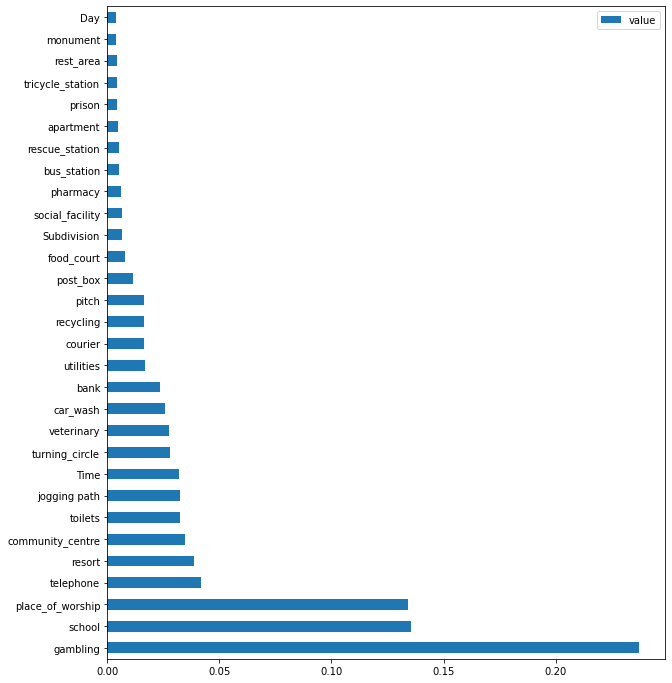

In [74]:
f.plot.barh(figsize=(10,12))

# Time Series Analysis

In [75]:
import lightgbm as lgb
from pandas.plotting import register_matplotlib_converters
from IPython.display import display
from tsa_functions import *

import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

def rmsse(y_true, y_pred, ts):
    score = np.sqrt(np.mean((y_true - y_pred)**2)/np.mean((ts[1:] - ts[:-1])**2))
    return score

### Prepare Dataset

In [76]:
cities = pd.merge(df4[['name_1', 'name_2','substation','ratio_pop']], 
                 df4a[['code', 'matchingname2']], 
                 left_on='substation',
                 right_on='matchingname2', how='inner')

In [77]:
tsa = pd.merge(cities, demand, left_on='code', right_on='RESOURCE_ID', how='inner')
tsa['energy_demand'] = tsa['ratio_pop'] * tsa['MW']

In [78]:
heirarchical_tsa = pd.pivot_table(tsa, values='energy_demand', 
                                 index=['DELIVERY_DATE', 'DELIVERY_HOUR'],
                                 columns=['name_1', 'name_2'] ).fillna(0).T
heirarchical_tsa

DELIVERY_DATE          02/01/2021                                          \
DELIVERY_HOUR                1.0       2.0       3.0       4.0       5.0    
name_1   name_2                                                             
Abra     Bangued         0.357554  0.351281  0.334553  0.326189  0.338735   
         Boliney         0.032590  0.031065  0.029540  0.029350  0.029540   
         Bucay           0.156108  0.148805  0.141502  0.140589  0.141502   
         Bucloc          0.022812  0.021745  0.020677  0.020544  0.020677   
         Daguioman       0.019045  0.018154  0.017263  0.017152  0.017263   
...                           ...       ...       ...       ...       ...   
Zambales San Felipe      0.678784  0.649776  0.620768  0.606264  0.614967   
         San Marcelino   0.752190  0.736388  0.692141  0.685820  0.698462   
         San Narciso     0.633659  0.620346  0.583072  0.577747  0.588397   
         Santa Cruz      0.588608  0.562864  0.532439  0.521907  0.530098   
         Subic           2.340939  2.291760  2.154058  2.134386  2.173729   

DELIVERY_DATE                                                             ...  \
DELIVERY_HOUR               6.0       7.0       8.0       9.0       10.0  ...   
name_1   name_2                                                           ...   
Abra     Bangued        0.357554  0.388918  0.407737  0.428646  0.466283  ...   
         Boliney        0.032209  0.037545  0.044025  0.043262  0.046312  ...   
         Bucay          0.154282  0.179844  0.210883  0.207231  0.221838  ...   
         Bucloc         0.022545  0.026280  0.030816  0.030283  0.032417  ...   
         Daguioman      0.018822  0.021941  0.025727  0.025282  0.027064  ...   
...                          ...       ...       ...       ...       ...  ...   
Zambales San Felipe     0.638173  0.684586  0.733899  0.783212  0.844129  ...   
         San Marcelino  0.720586  0.745869  0.786955  0.834362  0.922855  ...   
         San Narciso    0.607034  0.628334  0.662945  0.702882  0.777430  ...   
         Santa Cruz     0.549992  0.597969  0.620203  0.655309  0.739563  ...   
         Subic          2.242580  2.321268  2.449134  2.596672  2.872077  ...   

DELIVERY_DATE          04/30/2021                                          \
DELIVERY_HOUR                15.0      16.0      17.0      18.0      19.0   
name_1   name_2                                                             
Abra     Bangued         0.621014  0.610559  0.562467  0.510194  0.531103   
         Boliney         0.060415  0.057937  0.057937  0.052982  0.055269   
         Bucay           0.289393  0.277526  0.277526  0.253790  0.264745   
         Bucloc          0.042289  0.040555  0.040555  0.037086  0.038687   
         Daguioman       0.035305  0.033858  0.033858  0.030962  0.032298   
...                           ...       ...       ...       ...       ...   
Zambales San Felipe      0.617868  0.571455  0.542447  0.513439  0.588860   
         San Marcelino   2.060622  2.038499  1.877315  1.769859  1.889957   
         San Narciso     1.735905  1.717268  1.581484  1.490961  1.592134   
         Santa Cruz      1.262640  1.219343  1.101153  0.988815  0.986474   
         Subic           6.412993  6.344142  5.842512  5.508092  5.881856   

DELIVERY_DATE                                                             
DELIVERY_HOUR               20.0      21.0      22.0      23.0      24.0  
name_1   name_2                                                           
Abra     Bangued        0.583377  0.610559  0.633560  0.604287  0.556195  
         Boliney        0.070707  0.075281  0.074328  0.068991  0.062130  
         Bucay          0.338691  0.360601  0.356036  0.330474  0.297610  
         Bucloc         0.049493  0.052694  0.052027  0.048292  0.043489  
         Daguioman      0.041320  0.043993  0.043436  0.040317  0.036308  
...                          ...       ...       ...       ...       ...  
Zambales San Felipe     0.678784

### Split Train-Test

In [79]:
tsa_train = heirarchical_tsa.iloc[:, 1008:2112].T
tsa_train.head()

name_1                           Abra                                          \
name_2                        Bangued   Boliney     Bucay    Bucloc Daguioman   
DELIVERY_DATE DELIVERY_HOUR                                                     
03/15/2021    1.0            0.514375  0.051267  0.245574  0.035885  0.029960   
              2.0            0.487193  0.048599  0.232793  0.034018  0.028400   
              3.0            0.476738  0.047455  0.227315  0.033217  0.027732   
              4.0            0.466283  0.045359  0.217273  0.031750  0.026507   
              5.0            0.474647  0.045740  0.219099  0.032017  0.026730   

name_1                                                               \
name_2                        Danglas   Dolores    La Paz     Lacub   
DELIVERY_DATE DELIVERY_HOUR                                           
03/15/2021    1.0            0.044770  0.120843  0.164865  0.036344   
              2.0            0.042404  0.114457  0.156153  0.034423   
              3.0            0.041494  0.112001  0.152802  0.033684   
              4.0            0.040584  0.109545  0.149451  0.032946   
              5.0            0.041312  0.111510  0.152132  0.033537   

name_1                                   ...  Zambales            \
name_2                      Lagangilang  ...       Iba  Masinloc   
DELIVERY_DATE DELIVERY_HOUR              ...                       
03/15/2021    1.0              0.152242  ...  1.516702  1.433008   
              2.0              0.144197  ...  1.434548  1.355387   
              3.0              0.141102  ...  1.402950  1.325533   
              4.0              0.138008  ...  1.365032  1.289708   
              5.0              0.140483  ...  1.365032  1.289708   

name_1                                                                      \
name_2                      Olongapo City   Palauig San Antonio San Felipe   
DELIVERY_DATE DELIVERY_HOUR                                                  
03/15/2021    1.0                     0.0  1.049463    1.369920   0.696189   
              2.0                     0.0  0.992617    1.324365   0.658479   
              3.0                     0.0  0.970754    1.259285   0.643975   
              4.0                     0.0  0.944517    1.220238   0.626570   
              5.0                     0.0  0.944517    1.226746   0.626570   

name_1                                                                      
name_2                      San Marcelino San Narciso Santa Cruz     Subic  
DELIVERY_DATE DELIVERY_HOUR                                                 
03/15/2021    1.0                1.330555    1.120883   0.951368  4.140905  
              2.0                1.286308    1.083609   0.897539  4.003203  
              3.0                1.223099    1.030361   0.861263  3.806485  
              4.0                1.185174    0.998412   0.826157  3.688455  
              5.0                1.191495    1.003736   0.815626  3.708127  

[5 rows x 592 columns]

In [80]:
tsa_test = heirarchical_tsa.iloc[:, 2112:].T
tsa_test.head()

name_1                           Abra                                          \
name_2                        Bangued   Boliney     Bucay    Bucloc Daguioman   
DELIVERY_DATE DELIVERY_HOUR                                                     
04/30/2021    1.0            0.508103  0.056794  0.272048  0.039754  0.033189   
              2.0            0.487193  0.053935  0.258354  0.037753  0.031519   
              3.0            0.478829  0.052029  0.249225  0.036419  0.030405   
              4.0            0.451647  0.049552  0.237357  0.034685  0.028957   
              5.0            0.441192  0.046693  0.223664  0.032684  0.027287   

name_1                                                               \
name_2                        Danglas   Dolores    La Paz     Lacub   
DELIVERY_DATE DELIVERY_HOUR                                           
04/30/2021    1.0            0.044224  0.119369  0.162855  0.035900   
              2.0            0.042404  0.114457  0.156153  0.034423   
              3.0            0.041676  0.112492  0.153472  0.033832   
              4.0            0.039310  0.106106  0.144760  0.031912   
              5.0            0.038400  0.103650  0.141409  0.031173   

name_1                                   ...  Zambales            \
name_2                      Lagangilang  ...       Iba  Masinloc   
DELIVERY_DATE DELIVERY_HOUR              ...                       
04/30/2021    1.0              0.150385  ...  1.213362  1.146407   
              2.0              0.144197  ...  1.150166  1.086698   
              3.0              0.141721  ...  1.131207  1.068785   
              4.0              0.133676  ...  1.086970  1.026989   
              5.0              0.130581  ...  1.036413  0.979222   

name_1                                                                      \
name_2                      Olongapo City   Palauig San Antonio San Felipe   
DELIVERY_DATE DELIVERY_HOUR                                                  
04/30/2021    1.0                     0.0  0.839571    1.737619   0.556951   
              2.0                     0.0  0.795843    1.672539   0.527943   
              3.0                     0.0  0.782725    1.626984   0.519241   
              4.0                     0.0  0.752115    1.552142   0.498935   
              5.0                     0.0  0.717133    1.483809   0.475729   

name_1                                                                      
name_2                      San Marcelino San Narciso Santa Cruz     Subic  
DELIVERY_DATE DELIVERY_HOUR                                                 
04/30/2021    1.0                1.687687    1.421738   1.048494  5.252360  
              2.0                1.624478    1.368489   0.999346  5.055642  
              3.0                1.580232    1.331215   0.977113  4.917940  
              4.0                1.507541    1.269979   0.931475  4.691714  
              5.0                1.441171    1.214068   0.881157  4.485161  

[5 rows x 592 columns]

In [81]:
# features = tsa_train.copy()
# features

### Prepare Exogenous Variables

In [82]:
features = pd.merge(features_count, df4[['shp_province', 'shp_municipality']],
         left_on=['name_1', 'name_2'], right_on=['shp_province', 'shp_municipality'], how='right').fillna(0).set_index(['shp_province', 'shp_municipality'])
features

name_1         name_2  BPI ATM  \
shp_province shp_municipality                                     
Abra         Bangued               Abra        Bangued      0.0   
             Boliney                  0              0      0.0   
             Bucay                    0              0      0.0   
             Bucloc                   0              0      0.0   
             Daguioman                0              0      0.0   
...                                 ...            ...      ...   
Zambales     Palauig           Zambales        Palauig      0.0   
             San Antonio       Zambales    San Antonio      0.0   
             San Felipe        Zambales     San Felipe      0.0   
             San Marcelino     Zambales  San Marcelino      0.0   
             Subic             Zambales          Subic      0.0   

                               Barangay Hall  Barangay Yakal Hall  \
shp_province shp_municipality                                       
Abra         Bangued                     0.0                  0.0   
             Boliney                     0.0                  0.0   
             Bucay                       0.0                  0.0   
             Bucloc                      0.0                  0.0   
             Daguioman                   0.0                  0.0   
...                                      ...                  ...   
Zambales     Palauig                     0.0                  0.0   
             San Antonio                 0.0                  0.0   
             San Felipe                  0.0                  0.0   
             San Marcelino               0.0                  0.0   
             Subic                       0.0                  0.0   

                               Barangay_Police_Outpost  Basketball Court  \
shp_province shp_municipality                                              
Abra         Bangued                               0.0               0.0   
             Boliney                               0.0               0.0   
             Bucay                                 0.0               0.0   
             Bucloc                                0.0               0.0   
             Daguioman                             0.0               0.0   
...                                                ...               ...   
Zambales     Palauig                               0.0               0.0   
             San Antonio                           0.0               0.0   
             San Felipe                            0.0               0.0   
             San Marcelino                         0.0               0.0   
             Subic                                 0.0               0.0   

                               Budget Accomodation  CheckPoint  Clubhouse  \
shp_province shp_municipality                                               
Abra         Bangued                           0.0         0.0        0.0   
             Boliney                           0.0         0.0        0.0   
             Bucay                             0.0         0.0        0.0   
             Bucloc                            0.0         0.0        0.0   
             Daguioman                         0.0         0.0        0.0   
...                                            ...         ...        ...   
Zambales     Palauig                           0.0         0.0        0.0   
             San Antonio                       0.0         0.0        0.0   
             San Felipe                        0.0         0.0        0.0   
             San Marcelino                     0.0         0.0        0.0   
             Subic                             0.0         0.0        0.0   

                               ...  water_point  waterwell  wayside_cross  \
shp_province shp_municipality  ...                                          
Abra         Bangued           ...          0.0        0.0            0.0   
             Boliney           ...       

In [86]:
top_features = list(f.index)
top_features.remove('Time')
top_features.remove('Day')

In [87]:
exogenous_data = features[top_features].T
exogenous_data

shp_province        Abra                                                   \
shp_municipality Bangued Boliney Bucay Bucloc Daguioman Malibcong Danglas   
gambling             0.0     0.0   0.0    0.0       0.0       0.0     0.0   
school               2.0     0.0   0.0    0.0       0.0       0.0     0.0   
place_of_worship     0.0     0.0   0.0    0.0       0.0       0.0     0.0   
telephone            0.0     0.0   0.0    0.0       0.0       0.0     0.0   
resort               0.0     0.0   0.0    0.0       0.0       0.0     0.0   
community_centre     1.0     0.0   0.0    0.0       0.0       0.0     0.0   
toilets              0.0     0.0   0.0    0.0       0.0       0.0     0.0   
jogging path         0.0     0.0   0.0    0.0       0.0       0.0     0.0   
turning_circle       0.0     0.0   0.0    0.0       0.0       0.0     0.0   
veterinary           0.0     0.0   0.0    0.0       0.0       0.0     0.0   
car_wash             0.0     0.0   0.0    0.0       0.0       0.0     0.0   
bank                 5.0     0.0   0.0    0.0       0.0       0.0     0.0   
utilities            0.0     0.0   0.0    0.0       0.0       0.0     0.0   
courier              0.0     0.0   0.0    0.0       0.0       0.0     0.0   
recycling            0.0     0.0   0.0    0.0       0.0       0.0     0.0   
pitch                0.0     0.0   0.0    0.0       0.0       0.0     0.0   
post_box             0.0     0.0   0.0    0.0       0.0       0.0     0.0   
food_court           0.0     0.0   0.0    0.0       0.0       0.0     0.0   
Subdivision          0.0     0.0   0.0    0.0       0.0       0.0     0.0   
social_facility      0.0     0.0   0.0    0.0       0.0       0.0     0.0   
pharmacy             1.0     0.0   0.0    0.0       0.0       0.0     0.0   
bus_station          0.0     0.0   0.0    0.0       0.0       0.0     0.0   
rescue_station       0.0     0.0   0.0    0.0       0.0       0.0     0.0   
apartment            0.0     0.0   0.0    0.0       0.0       0.0     0.0   
prison               0.0     0.0   0.0    0.0       0.0       0.0     0.0   
tricycle_station     0.0     0.0   0.0    0.0       0.0       0.0     0.0   
rest_area            0.0     0.0   0.0    0.0       0.0       0.0     0.0   
monument             0.0     0.0   0.0    0.0       0.0       0.0     0.0   

shp_province                           ...   Zambales                  \
shp_municipality Dolores La Paz Lacub  ... Santa Cruz Candelaria  Iba   
gambling             0.0    0.0   0.0  ...        0.0        0.0  0.0   
school               0.0    0.0   0.0  ...        2.0        0.0  3.0   
place_of_worship     0.0    0.0   0.0  ...        2.0        0.0  2.0   
telephone            0.0    0.0   0.0  ...        0.0        0.0  0.0   
resort               0.0    0.0   0.0  ...        0.0        0.0  0.0   
community_centre     0.0    0.0   0.0  ...        0.0        0.0  1.0   
toilets              0.0    0.0   0.0  ...        0.0        0.0  0.0   
jogging path         0.0    0.0   0.0  ...        0.0        0.0  0.0   
turning_circle       0.0    0.0   0.0  ...        0.0        0.0  0.0   
veterinary           0.0    0.0   0.0  ...        0.0        0.0  0.0   
car_wash             0.0    0.0   0.0  ...        0.0        0.0  0.0   
bank                 0.0    0.0   0.0  ...        0.0        1.0  4.0   
utilities            0.0    0.0   0.0  ...        0.0        0.0  0.0   
courier              0.0    0.0   0.0  ...        0.0        0.0  0.0   
recycling            0.0    0.0   0.0  ...        0.0        0.0  0.0   
pitch                0.0    0.0   0.0  ...        1.0        0.0  0.0   
post_box             0.0    0.0   0.0  ...        0.0        0.0  0.0   
food_court           0.0    0.0   0.0  ...        0.0        0.0  0.0   
Subdivision          0.0    0.0   0.0  ...        0.0        0.0  0.0   
social_facility      0.0    0.0   0.0  ...        0.0        0.0  0.0   
pharmacy             0.0    0.0   0.0  ...        0.0        0.0  3.0   
bus_statio

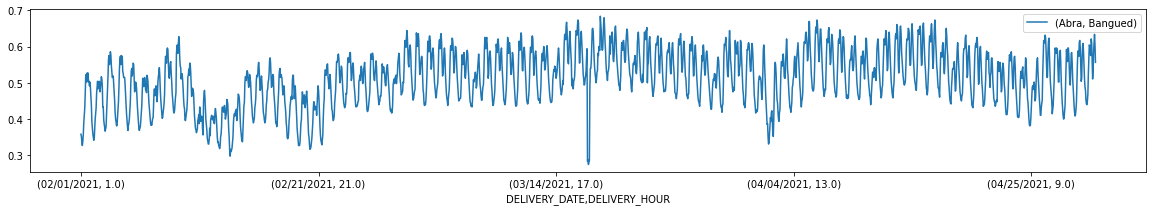

In [88]:
series = heirarchical_tsa.iloc[0]

series.plot(figsize=(20,3))
plt.legend()
plt.show()

In [89]:
def split_arrays(series, test_size, w, h):
    ts_train = series[:-test_size]
    ts_test = series[-test_size-w:]
    return ts_train, ts_test

In [90]:
def create_feature_target(series, w, h):
    features, target = [], []
    for i in range(len(series)-w-h+1):
        features.append(series[i:i+w])
        target.append(series[i+w: i+w+h])
    return np.array(features), np.array(target)

In [91]:
from sklearn.multioutput import MultiOutputRegressor
w = 1*24
def direct_forecasting(train, val_size, h):
    rmse_mat = []
    for i in range(val_size, h-1, -1):
        ts_train = train[:-i].to_numpy()
        if i == h:
            ts_val = train[-i-w:].to_numpy()
        else: 
            ts_val = train[-i-w:-i+h].to_numpy()

        train_features, train_target = create_feature_target(ts_train, w, h)
        val_features, val_target = create_feature_target(ts_val, w, h)

        model = MultiOutputRegressor(lgb.LGBMRegressor(random_state=1), n_jobs = -1)
        model.fit(train_features, train_target)

        forecast_direct = model.predict(val_features)

        rmse_mat.append(rmse(val_target, forecast_direct))

    avg_rmse = np.nanmean(np.asarray(rmse_mat), axis=0)
    std_rmse = np.nanstd(np.asarray(rmse_mat), axis=0)
 
    return forecast_direct, avg_rmse, std_rmse                                                            

In [101]:
train = tsa_train.iloc[:,-8]
val_size = 24
h = 12

forecast_direct, avg_rmse, std_rmse = direct_forecasting(train, val_size, h)
forecast_direct, avg_rmse, std_rmse

(array([[ 0.52515573,  0.66785137,  0.91311536,  1.125023  ,  1.03315509,
          0.62370945, -0.09464494,  0.90034593,  0.22458895,  0.52648564,
          0.65853831,  0.69050174]]),
 0.31794923790559604,
 0.09344731493061499)

In [102]:
def create_feature_target_with_exogenous(series, exo, w, h):
    features, exo_features, target = [], [], []
    for i in range(len(series)-w-h+1):
        features.append(series[i:i+w])
        target.append(series[i+w: i+w+h])
    
    for i in range(np.array(features).shape[0]):
        exo_features.append(exo)
    return np.concatenate((features, exo_features), axis=1), np.array(target)

In [103]:
from sklearn.multioutput import MultiOutputRegressor
w = 1*24
def direct_forecasting_with_exogenous(train, exo, val_size, h):
    rmse_mat = []
    for i in range(val_size, h-1, -1):
        ts_train = train[:-i].to_numpy()
        if i == h:
            ts_val = train[-i-w:].to_numpy()
        else: 
            ts_val = train[-i-w:-i+h].to_numpy()

        train_features, train_target = create_feature_target_with_exogenous(ts_train, exo, w, h)
        val_features, val_target = create_feature_target_with_exogenous(ts_val, exo, w, h)

        model = MultiOutputRegressor(lgb.LGBMRegressor(random_state=1), n_jobs = -1)
        model.fit(train_features, train_target)

        forecast_direct = model.predict(val_features)

        rmse_mat.append(rmse(val_target, forecast_direct))

    avg_rmse = np.nanmean(np.asarray(rmse_mat), axis=0)
    std_rmse = np.nanstd(np.asarray(rmse_mat), axis=0)
 
    return forecast_direct, avg_rmse, std_rmse                                                            

In [104]:
train = tsa_train.iloc[:,-8]
exo = exogenous_data.iloc[:,-6]
val_size = 24
h = 12

forecast_direct, avg_rmse, std_rmse = direct_forecasting_with_exogenous(train, exo, val_size, h)
forecast_direct, avg_rmse, std_rmse

(array([[ 0.52515573,  0.66785137,  0.91311536,  1.125023  ,  1.03315509,
          0.62370945, -0.09464494,  0.90034593,  0.22458895,  0.52648564,
          0.65853831,  0.69050174]]),
 0.31794923790559604,
 0.09344731493061499)

In [105]:
res = STL(series.to_numpy(), period=24, seasonal=25, robust=True).fit()

# fig = res.plot()
# fig.set_size_inches(20,12)
# fig.tight_layout()
# plt.show()

In [106]:
seasonal_daily = res.seasonal
seasonal_adjusted = series - seasonal_daily

res = STL(seasonal_adjusted.to_numpy(), period=7*24, seasonal=7*24+1, robust=True).fit()

# fig = res.plot()
# fig.set_size_inches(20,12)
# fig.tight_layout()
# plt.show()

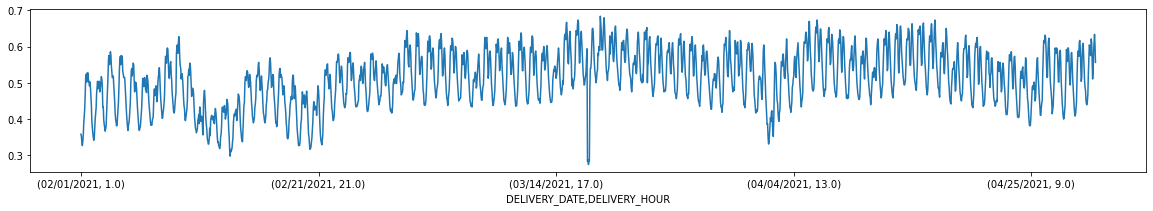

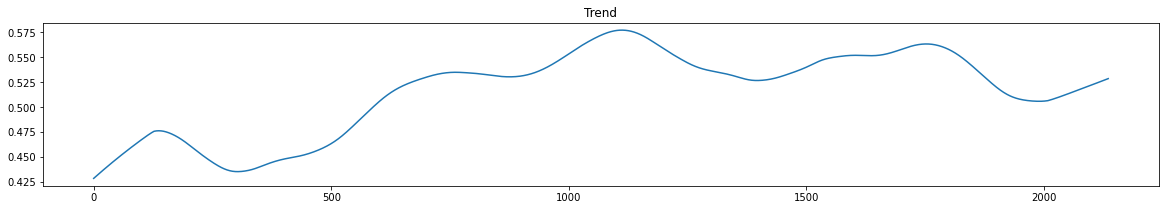

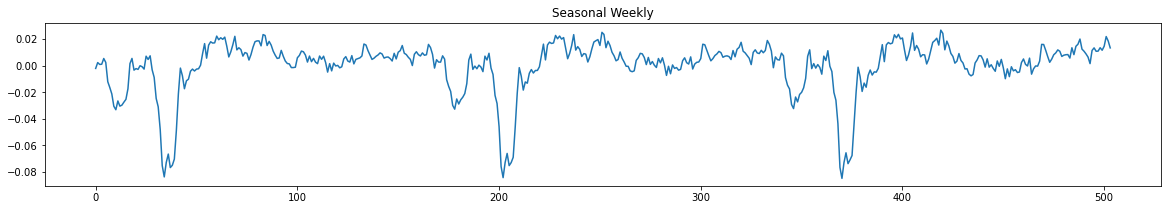

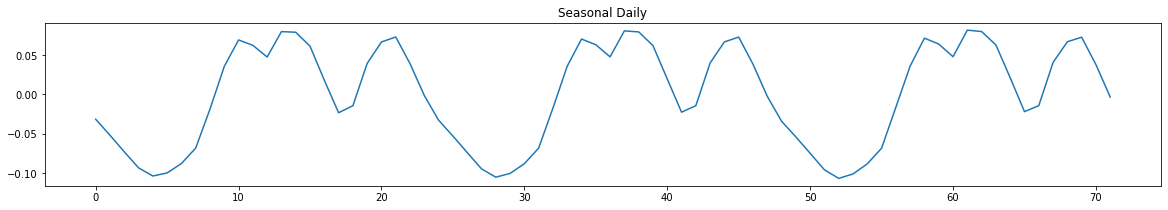

In [107]:
seasonal_weekly = res.seasonal
trend = res.trend
residual = res.resid

series.plot(figsize=(20,3))
plt.show()

pd.Series(trend).plot(figsize=(20,3), title='Trend')
plt.show()

pd.Series(seasonal_weekly[-3*7*24:]).plot(figsize=(20,3), title='Seasonal Weekly')
plt.show()

pd.Series(seasonal_daily[-3*24:]).plot(figsize=(20,3), title='Seasonal Daily')
plt.show()

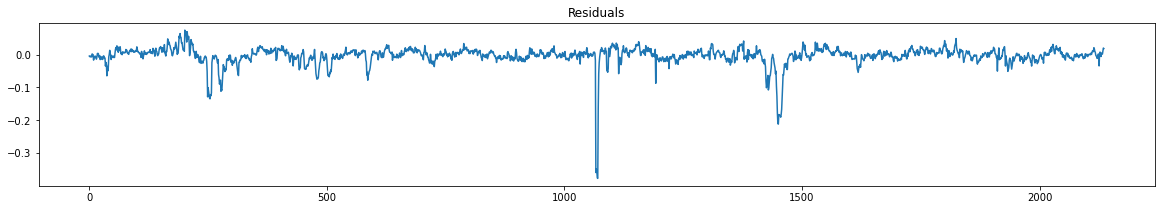

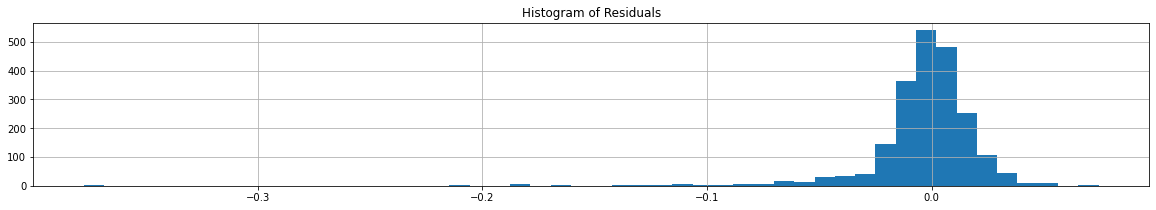

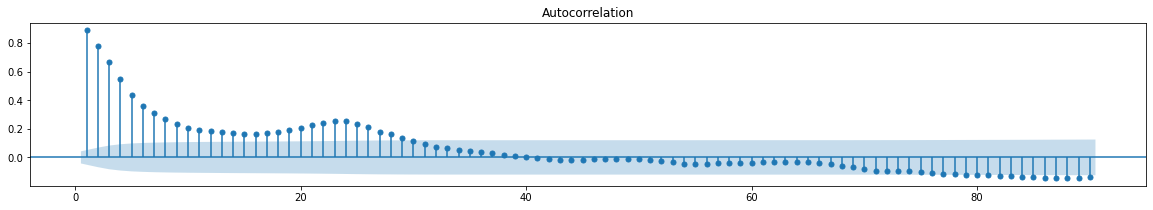

In [108]:
pd.Series(residual).plot(figsize=(20,3), title='Residuals')
plt.show()

ax = pd.Series(residual).hist(figsize=(20,3), bins=50)
ax.set_title('Histogram of Residuals')
plt.show()

fig, ax = plt.subplots(figsize=(20,3))
sm.graphics.tsa.plot_acf(residual, lags=90, zero=False, ax=ax)
plt.show()

In [ ]:
# forecasted_seasonal_daily = snaivef(seasonal_daily, h=24, m=24)
# forecasted_seasonal_weekly = snaivef(seasonal_weekly, h=24, m=24*7)

# # model = ETSModel(trend, error='add', trend='add').fit()
# # forecasted_trend = model.forecast(24)

In [ ]:
# def train_test_split(series, test_size, w, h):
#     ts_train = series[:-test_size]
#     ts_test = series[-test_size-w:]
#     return ts_train, ts_test

# def create_xy(series, w, h):
#     features, target = [], []
#     for i in range(len(series)-w-h+1):
#         features.append(series[i:i+w])
#         target.append(series[i+w: i+w+h])
#     return np.array(features), np.array(target)

In [ ]:
# w = 24*7
# h = 1
# test_size = 24

# train_x, train_y = create_xy(trend, w, h)

# model = lgb.LGBMRegressor(random_state=1).fit(train_x, train_y) 

# forecasted_trend = []
# x = np.append(train_x[-1, 1:], train_y[-1]).reshape(1,-1)

# for i in range(test_size):
#     y_hat = model.predict(x)
#     x = np.append(x[:1, 1:], y_hat).reshape(1, -1)
#     forecasted_trend.append(y_hat) 
    
# forecasted_trend = np.concatenate(forecasted_trend).ravel()

In [ ]:
# w = 24*7
# h = 1
# test_size = 24

# train_x, train_y = create_xy(residual, w, h)

# model = lgb.LGBMRegressor(random_state=1).fit(train_x, train_y) 

# forecasted_residual = []
# x = np.append(train_x[-1, 1:], train_y[-1]).reshape(1,-1)

# for i in range(test_size):
#     y_hat = model.predict(x)
#     x = np.append(x[:1, 1:], y_hat).reshape(1, -1)
#     forecasted_residual.append(y_hat) 
    
# forecasted_residual = np.concatenate(forecasted_residual).ravel()

In [ ]:
# forecasts = pd.DataFrame([forecasted_seasonal_daily, 
#                           forecasted_seasonal_weekly, 
#                           forecasted_trend, 
#                           forecasted_residual]).T
# forecasts.columns = ['Seasonal_Daily', 'Seasonal_Weekly', 'Trend', 'Residuals']
# forecasts['Total'] = forecasts.sum(axis=1)
# forecasts.head()

# total_forecast = pd.DataFrame(forecasts.sum(axis=1))
# total_forecast.head()

In [ ]:
# df_acc = pd.DataFrame()

# rmse_list = []
# mae_list = []
# mase_list = []
# rmsse_list = []

# for num, store in enumerate(tsa_train.columns[:1]):
#     mae_list.append(mae(tsa_test[store].to_numpy(), total_forecast.loc[:, num].to_numpy()))
#     rmse_list.append(rmse(tsa_test[store].to_numpy(), total_forecast.loc[:, num].to_numpy()))
#     mase_list.append(mase(tsa_test[store].to_numpy(), total_forecast.loc[:, num].to_numpy(), 
#                           tsa_train[store].to_numpy()))
#     rmsse_list.append(rmsse(tsa_test[store].to_numpy(), total_forecast.loc[:, num].to_numpy(), 
#                             tsa_train[store].to_numpy()))

# df_acc['MAE'] = np.asarray(mae_list)
# df_acc['RMSE'] = np.asarray(rmse_list)
# df_acc['MASE'] = np.asarray(mase_list)
# df_acc['RMSSE'] = np.asarray(rmsse_list)
# display(df_acc)